# DANN with autoencoder

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torch.backends.cudnn as cudnn

from torch.autograd import Function

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms, datasets
import os

### Data Overview

In [2]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def get_backgrounds():
    backgrounds = []
    for file in os.listdir("./images/train"):
        if file.endswith('.jpg'):
            backgrounds.append(plt.imread(os.path.join("./images/train",file)))
    return np.array(backgrounds)
backgrounds = get_backgrounds()


def compose_image(image):
    image = (image > 0).astype(np.float32)
    image = image.reshape([28,28])*255.0
    
    image = np.stack([image,image,image],axis=2)
    
    background = np.random.choice(backgrounds)
    w,h,_ = background.shape
    dw, dh,_ = image.shape
    x = np.random.randint(0,w-dw)
    y = np.random.randint(0,h-dh)
    
    temp = background[x:x+dw, y:y+dh]
    return np.abs(temp-image).astype(np.uint8)


class MNISTM(Dataset):
            
    def __init__(self, train=True,transform=None):
        if train:
            self.data = datasets.MNIST(root='.data/mnist',train=True, download=True)
        else:
            self.data = datasets.MNIST(root='.data/mnist',train=False, download=True)
        self.backgrounds = get_backgrounds()
        self.transform = transform
        self.images = []
        self.targets = []
        for index in range(len(self.data)):
            image = np.array(self.data.__getitem__(index)[0])
            target = self.data.__getitem__(index)[1]
            image = compose_image(image)
            if self.transform is not None:
                image = self.transform(image)
            self.images.append(image)
            self.targets.append(target)
        
    def __getitem__(self,index):
        
        #image = Image.fromarray(image.squeeze(), mode="RGB")
        image = self.images[index]
        target = self.targets[index]
        
        return image, target
        
    def __len__(self):
        return len(self.data)
    
kwargs =  {'num_workers': 4, 'pin_memory': True}

def get_mnistm_loaders(data_aug = False, batch_size=128,test_batch_size=1000):
    if data_aug:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(28),
            transforms.RandomCrop(28,padding=4),
            transforms.ToTensor()
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(28),
            transforms.ToTensor()
        ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(28),
        transforms.ToTensor()
    ])

    train_loader = DataLoader(
        MNISTM(train=True,transform=train_transform),batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
    train_eval_loader = DataLoader(
        MNISTM(train=True, transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True, **kwargs)
    test_loader = DataLoader(
        MNISTM(train=False,transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True, **kwargs)
    return train_loader, train_eval_loader, test_loader


def get_mnist_loaders(data_aug = False, batch_size=128,test_batch_size=1000):
    if data_aug:
        train_transform = transforms.Compose(
            [transforms.Resize(28),
            transforms.RandomCrop(28,padding=4),
            transforms.Grayscale(3),
            transforms.ToTensor()
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize(28),
            transforms.Grayscale(3),
            transforms.ToTensor()
        ])
    test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.Grayscale(3),
        transforms.ToTensor()
    ])
  

    train_loader = DataLoader(
        datasets.MNIST(root='.data/mnist',train=True, download=True,transform=train_transform),batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
    train_eval_loader = DataLoader(
        datasets.MNIST(root='.data/mnist',train=True, download=True, transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True, **kwargs)
    test_loader = DataLoader(
        datasets.MNIST(root='.data/mnist',train=False, download=True, transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True, **kwargs)
    return train_loader, train_eval_loader, test_loader

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


In [3]:
loader_source, mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=128)
loader_target, mnistm_eval_loader,mnistm_test_loader = get_mnistm_loaders(batch_size=128)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


In [4]:
epoches = 201

### Base Line: DANN

In [5]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=5),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(2),
                    nn.ReLU(True),
                    nn.Conv2d(64, 50, kernel_size=5),
                    nn.BatchNorm2d(50),
                    nn.Dropout2d(),
                    nn.MaxPool2d(2),
                    nn.ReLU(True)
                )
                
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.classifier = nn.Sequential(
                    nn.Linear(50 * 4 * 4, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(100, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Linear(100, 10),
                )


        self.domain_classifier = nn.Sequential(
                    nn.Linear(50 * 4 * 4, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Linear(100, 2),
                )
    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

In [6]:
def train(source, target, net, criterion, optimizer, epoch, use_cuda=True):
    net.train() # Sets the module in training mode.

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0
    total = 0
    batch_size = 128

    data_target_iter = iter(target)
    len_dataloader = min(len(source), len(target))

    for batch_idx, (inputs, source_label) in enumerate(source):

        p = float(batch_idx + epoch * len_dataloader) / (epoches * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01/(1.+10*p)**0.75

        batch_size = inputs.size(0)
        total += batch_size

        # Feed source image to the network
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda:
            inputs, source_label, domain_label = inputs.cuda(), source_label.cuda(), domain_label.cuda()
            
        optimizer.zero_grad()
        inputs, source_label = Variable(inputs), Variable(source_label)
        
        class_output, domain_output = net(inputs, alpha)
        
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)

        # Feed target image to the network
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda:
            target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        class_output, domain_output = net(target_inputs, alpha)
        loss_t_domain = criterion(domain_output, domain_label)

        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss = loss_s_label + loss_s_domain + loss_t_domain
        loss.backward()
        optimizer.step()
    
    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total

In [7]:
criterion = nn.CrossEntropyLoss()

dann = DANN()
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    dann.cuda()
    criterion = criterion.cuda()
    
optimizer = optim.Adam(dann.parameters(), lr=0.001) 

history_DANN = []
for epoch in range(0, epoches):
    sl, sd, tl, td, total = train(loader_source, loader_target, dann, criterion, optimizer, epoch) 
    history_DANN.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


e: 0, sl: 0.922342, sd: 0.924813, tl: 0.484609, td: 0.912376
e: 20, sl: 0.970336, sd: 0.649656, tl: 0.892445, td: 0.631844
e: 40, sl: 0.971304, sd: 0.606120, tl: 0.912326, td: 0.591329
e: 60, sl: 0.975361, sd: 0.602981, tl: 0.920723, td: 0.576055
e: 80, sl: 0.977414, sd: 0.591964, tl: 0.928619, td: 0.577808
e: 100, sl: 0.979334, sd: 0.595152, tl: 0.932242, td: 0.572583
e: 120, sl: 0.980285, sd: 0.581898, tl: 0.936031, td: 0.573484
e: 140, sl: 0.981571, sd: 0.583016, tl: 0.938235, td: 0.574369
e: 160, sl: 0.982372, sd: 0.576339, tl: 0.937851, td: 0.570463
e: 180, sl: 0.983307, sd: 0.578843, tl: 0.939119, td: 0.567525
e: 200, sl: 0.985544, sd: 0.579410, tl: 0.940889, td: 0.569444


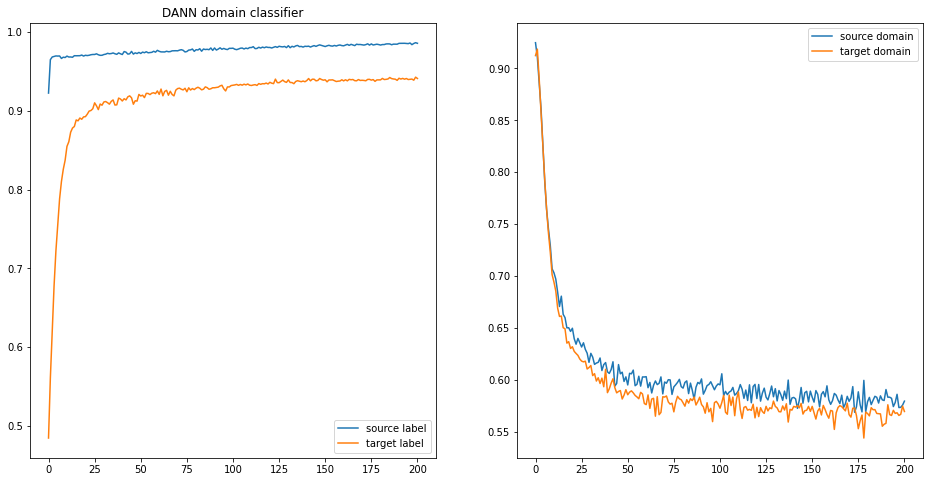

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
x = range(0, epoches)

history_DANN = np.array(history_DANN)

ax1.plot(x, history_DANN[:,0])
ax1.plot(x, history_DANN[:,2])
ax1.set_title("DANN classifier")
ax1.legend(['source label', 'target label'])

ax2.plot(x, history_DANN[:,1])
ax2.plot(x, history_DANN[:,3])
ax1.set_title("DANN domain classifier")
ax2.legend(['source domain', 'target domain'])

In [9]:
torch.save(dann, "./model_weight/dann")

### First Attempt: Follow the instruction of the paper

In [10]:
class DANN_with_autoencoder(nn.Module):
    def __init__(self):
        super(DANN_with_autoencoder, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(50, 64, 5, stride=2, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 5, stride=2, output_padding=1),
            nn.InstanceNorm2d(3),
            nn.ReLU(inplace=True),

            nn.Tanh()
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4* 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
        )
        
    def forward(self, input_data, alpha):
            input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
            feature = self.feature(input_data)

            reconstructed_data = self.decoder(feature)
            feature = feature.view(-1, 50 * 4 * 4)
            reverse_feature = ReverseLayerF.apply(feature, alpha)
            class_output = self.classifier(feature)
            domain_output = self.domain_classifier(reverse_feature)

            return class_output, domain_output, reconstructed_data

In [11]:
def train_with_autoencoder(source, target, net, criterion,criterion_construct, optimizer, use_cuda, epoch):
    net.train() # Sets the module in training mode.
    total = 0
    data_target_iter = iter(target)

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0

    len_dataloader = min(len(source), len(target))

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoch * len_dataloader) / (epoches * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01/(1.+10*p)**0.75
            
        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda: source_inputs, source_label, domain_label = source_inputs.cuda(), source_label.cuda(), domain_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        class_output, domain_output, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Source image
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Source images
        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)
        loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda: target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        class_output, domain_output, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Target image
        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Target images
        loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)
        loss_t_domain = criterion(domain_output, domain_label)

        loss = loss_s_label + loss_s_domain + loss_t_domain + loss_construct_tt + loss_construct_ss

        loss.backward()
        optimizer.step()

    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total

In [12]:
def generate_image(net, source, target, epoches):
    data_target_iter = iter(target)
    len_dataloader = min(len(source), len(target))
    
    source_reconstrueted = []
    source_label_lst = []
    target_reconstructed = []
    target_label_lst = []
    for batch_idx, (source_inputs, source_label) in enumerate(source):
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoches * len_dataloader) / (epoches * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)

        source_inputs, source_label = source_inputs.cuda(), source_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        _, _, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        target_inputs, target_label = target_inputs.cuda(), target_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        _, _, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        source_reconstrueted.extend(reconstruct_source.data.cpu().detach())
        source_label_lst.extend(source_label.cpu().detach().numpy())
        target_reconstructed.extend(reconstruct_target.data.cpu().detach())
        target_label_lst.extend(target_label.cpu().detach().numpy())

    return source_reconstrueted, target_reconstructed, source_label_lst, target_label_lst
    

In [13]:
def show_img(source, target, source_label, target_label):
    num_row = 4
    num_col = 5
    num = 10
    images = source[:num]
    labels = source_label[:num]

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        
        image =  images[i].transpose(0,2).transpose(0,1)

        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))


    images = target[:num]
    labels = target_label[:num]
    for i in range(10,20):
        ax = axes[i//num_col, i%num_col]
        image = images[i - 10].transpose(0,2).transpose(0,1)
        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(labels[i - 10]))
    plt.tight_layout()
    plt.show()

#### Use L2 loss as reconstruction loss

In [14]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.MSELoss()
dauto_l2 = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    dauto_l2.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(dauto_l2.parameters(), lr=0.001) 

In [15]:
history_DAtuo_L2 = []
for epoch in range(0, epoches):
    sl, sd, tl, td, total = train_with_autoencoder(loader_source, loader_target, dauto_l2, criterion, criterion_construct, optimizer, True, epoch) 
    history_DAtuo_L2.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


e: 0, sl: 0.921625, sd: 0.945346, tl: 0.422877, td: 0.916049
e: 20, sl: 0.966112, sd: 0.658954, tl: 0.873731, td: 0.656183
e: 40, sl: 0.969485, sd: 0.622963, tl: 0.901442, td: 0.609041
e: 60, sl: 0.972155, sd: 0.606237, tl: 0.917618, td: 0.585871
e: 80, sl: 0.974142, sd: 0.602013, tl: 0.924863, td: 0.587106
e: 100, sl: 0.974876, sd: 0.589977, tl: 0.927651, td: 0.580612
e: 120, sl: 0.976262, sd: 0.587640, tl: 0.925030, td: 0.577591
e: 140, sl: 0.978215, sd: 0.585771, tl: 0.930422, td: 0.570997
e: 160, sl: 0.979701, sd: 0.593533, tl: 0.933928, td: 0.567775
e: 180, sl: 0.980869, sd: 0.592314, tl: 0.933878, td: 0.561582
e: 200, sl: 0.981220, sd: 0.587891, tl: 0.935480, td: 0.570146


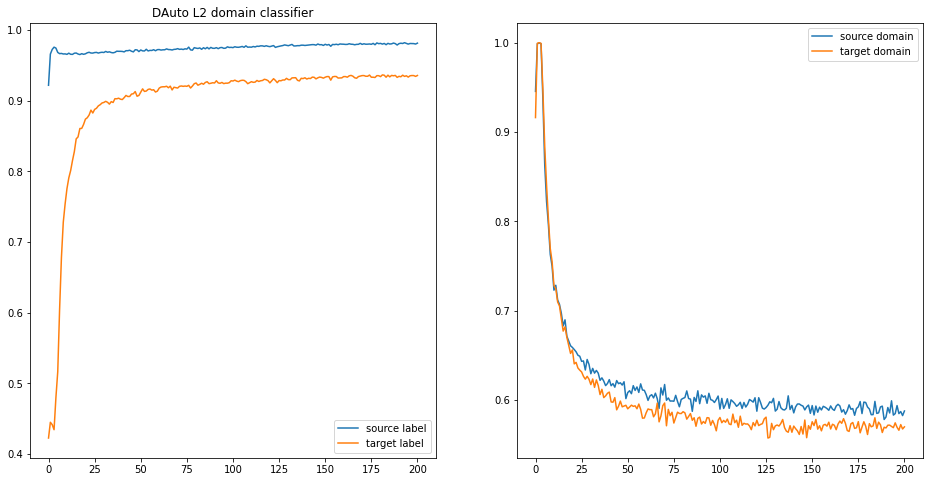

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
x = range(0, epoches)

history_DAtuo_L2 = np.array(history_DAtuo_L2)

ax1.plot(x, history_DAtuo_L2[:,0])
ax1.plot(x, history_DAtuo_L2[:,2])
ax1.set_title("DAuto L2 classifier")
ax1.legend(['source label', 'target label'])

ax2.plot(x, history_DAtuo_L2[:,1])
ax2.plot(x, history_DAtuo_L2[:,3])
ax1.set_title("DAuto L2 domain classifier")
ax2.legend(['source domain', 'target domain'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


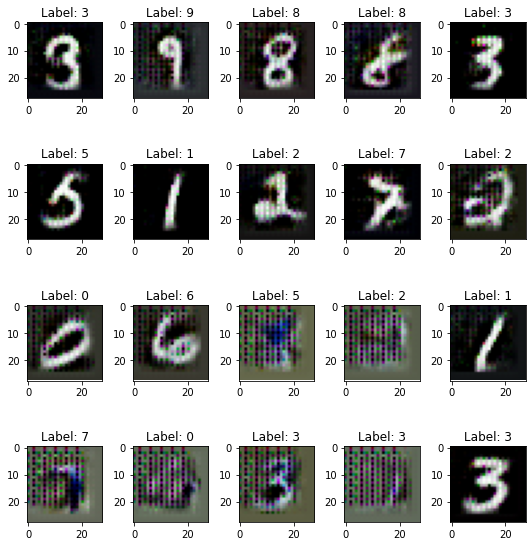

In [17]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(dauto_l2, loader_source, loader_target, 200)
show_img(source_reconstrueted, target_reconstructed, source_label, target_label)

In [18]:
torch.save(dauto_l2, "./model_weight/dauto_l2")

#### Use L1 loss as reconstruction loss

In [19]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.L1Loss()
dauto_l1 = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    dauto_l1.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(dauto_l1.parameters(), lr=0.001) 


In [20]:
history_DAtuo_L1 = []
for epoch in range(0, epoches):
    sl, sd, tl, td, total = train_with_autoencoder(loader_source, loader_target, dauto_l1, criterion, criterion_construct, optimizer, True, epoch) 
    history_DAtuo_L1.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


e: 0, sl: 0.924479, sd: 0.946665, tl: 0.419254, td: 0.927350
e: 20, sl: 0.959285, sd: 0.708033, tl: 0.717615, td: 0.715745
e: 40, sl: 0.963859, sd: 0.631961, tl: 0.854267, td: 0.641543
e: 60, sl: 0.967732, sd: 0.612397, tl: 0.880859, td: 0.610877
e: 80, sl: 0.970903, sd: 0.605686, tl: 0.899806, td: 0.600027
e: 100, sl: 0.972773, sd: 0.615168, tl: 0.905332, td: 0.609458
e: 120, sl: 0.976412, sd: 0.588492, tl: 0.911959, td: 0.595970
e: 140, sl: 0.975377, sd: 0.600611, tl: 0.909472, td: 0.599142
e: 160, sl: 0.975811, sd: 0.599676, tl: 0.912644, td: 0.603799
e: 180, sl: 0.975110, sd: 0.600694, tl: 0.915214, td: 0.595503
e: 200, sl: 0.982405, sd: 0.586271, tl: 0.916466, td: 0.598858


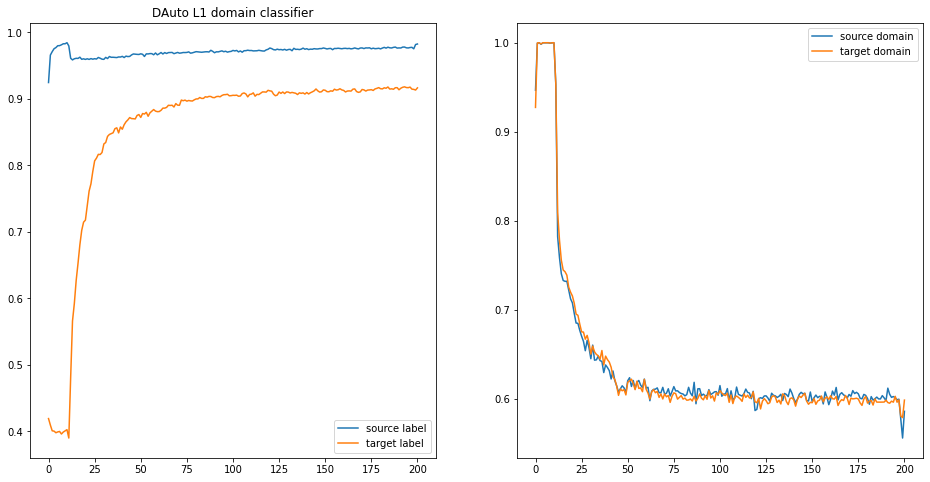

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
x = range(0, epoches)

history_DAtuo_L1 = np.array(history_DAtuo_L1)

ax1.plot(x, history_DAtuo_L1[:,0])
ax1.plot(x, history_DAtuo_L1[:,2])
ax1.set_title("DAuto L1 classifier")
ax1.legend(['source label', 'target label'])

ax2.plot(x, history_DAtuo_L1[:,1])
ax2.plot(x, history_DAtuo_L1[:,3])
ax1.set_title("DAuto L1 domain classifier")
ax2.legend(['source domain', 'target domain'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


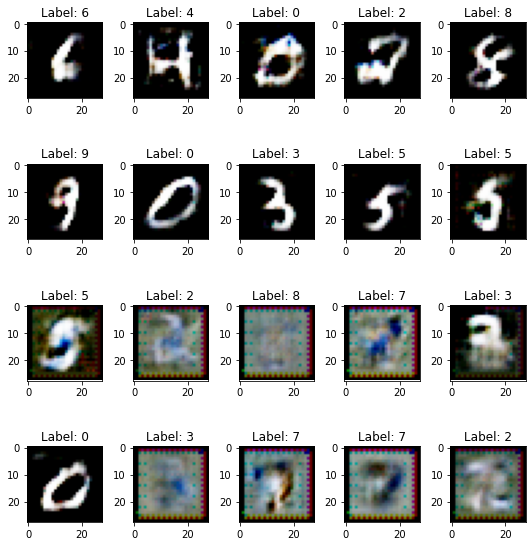

In [22]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(dauto_l1, loader_source, loader_target, 200)
show_img(source_reconstrueted, target_reconstructed, source_label, target_label)

In [23]:
torch.save(dauto_l1, "./model_weight/dauto_l1")

### Second Attempt: Add reconstrction loss between source reconstructed image and target reconstructed image

#### L1 loss

In [24]:
def train_with_autoencoder_v2(source, target, net, criterion,criterion_construct, optimizer, use_cuda, epoch):
    net.train() # Sets the module in training mode.
    total = 0
    data_target_iter = iter(target)

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0

    len_dataloader = min(len(source), len(target))

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoch * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01/(1.+10*p)**0.75

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda: source_inputs, source_label, domain_label = source_inputs.cuda(), source_label.cuda(), domain_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        class_output, domain_output, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Source image
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Source images
        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)
        loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda: target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        class_output, domain_output, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Target image
        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Target images
        loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)
        loss_t_domain = criterion(domain_output, domain_label)

        loss_construct_ts = criterion_construct(reconstruct_target, reconstruct_source)

        loss = loss_s_label + loss_s_domain + loss_t_domain + loss_construct_tt + loss_construct_ts + loss_construct_ss

        loss.backward()
        optimizer.step()


    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total



In [25]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.L1Loss()
dauto_v2_l1 = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    dauto_v2_l1.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(dauto_v2_l1.parameters(), lr=0.001) 

In [26]:
history_DAtuo_v2_L1 = []
for epoch in range(0, epoches):
    sl, sd, tl, td, total = train_with_autoencoder_v2(loader_source, loader_target, dauto_v2_l1, criterion, criterion_construct, optimizer,True, epoch) 
    history_DAtuo_v2_L1.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


e: 0, sl: 0.923227, sd: 0.871611, tl: 0.538729, td: 0.837740
e: 20, sl: 0.966947, sd: 0.639957, tl: 0.895182, td: 0.626669
e: 40, sl: 0.972155, sd: 0.609776, tl: 0.912927, td: 0.599493
e: 60, sl: 0.973591, sd: 0.606821, tl: 0.921074, td: 0.584402
e: 80, sl: 0.976045, sd: 0.593984, tl: 0.926933, td: 0.574352
e: 100, sl: 0.977080, sd: 0.596454, tl: 0.930622, td: 0.576606
e: 120, sl: 0.979884, sd: 0.585938, tl: 0.932075, td: 0.567408
e: 140, sl: 0.980085, sd: 0.588492, tl: 0.935263, td: 0.575204
e: 160, sl: 0.979768, sd: 0.578175, tl: 0.931924, td: 0.569695
e: 180, sl: 0.983373, sd: 0.589410, tl: 0.938502, td: 0.567925
e: 200, sl: 0.984024, sd: 0.586238, tl: 0.938351, td: 0.562450


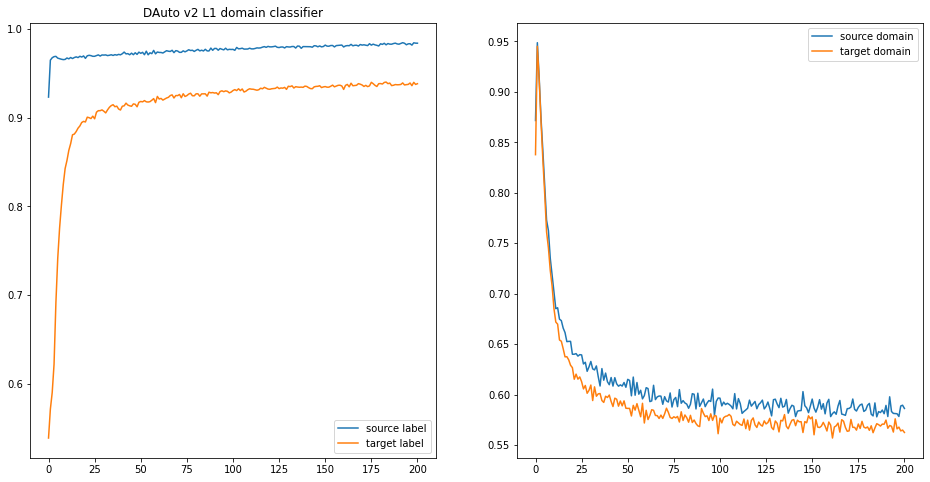

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
x = range(0, epoches)

history_DAtuo_v2_L1 = np.array(history_DAtuo_v2_L1)

ax1.plot(x, history_DAtuo_v2_L1[:,0])
ax1.plot(x, history_DAtuo_v2_L1[:,2])
ax1.set_title("DAuto v2 L1 classifier")
ax1.legend(['source label', 'target label'])

ax2.plot(x, history_DAtuo_v2_L1[:,1])
ax2.plot(x, history_DAtuo_v2_L1[:,3])
ax1.set_title("DAuto v2 L1 domain classifier")
ax2.legend(['source domain', 'target domain'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


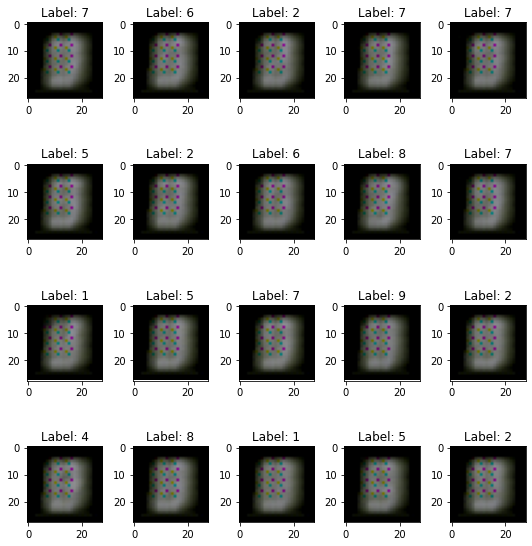

In [28]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(dauto_v2_l1, loader_source, loader_target, 200)
show_img(source_reconstrueted, target_reconstructed, source_label, target_label)

In [29]:
torch.save(dauto_v2_l1, "./model_weight/dauto_v2_l1")

#### L2 Loss

In [30]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.MSELoss()
dauto_v2_l2 = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    dauto_v2_l2.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(dauto_v2_l2.parameters(), lr=0.001) 

In [31]:
history_DAtuo_v2_L2 = []
for epoch in range(0, epoches):
    sl, sd, tl, td, total = train_with_autoencoder_v2(loader_source, loader_target, dauto_v2_l2, criterion, criterion_construct, optimizer,True, epoch) 
    history_DAtuo_v2_L2.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


e: 0, sl: 0.921925, sd: 0.894331, tl: 0.498715, td: 0.878422
e: 20, sl: 0.969635, sd: 0.650958, tl: 0.891827, td: 0.637637
e: 40, sl: 0.970570, sd: 0.610360, tl: 0.911458, td: 0.601329
e: 60, sl: 0.972890, sd: 0.594568, tl: 0.921775, td: 0.590895
e: 80, sl: 0.975227, sd: 0.583033, tl: 0.927501, td: 0.582031
e: 100, sl: 0.978299, sd: 0.591263, tl: 0.931791, td: 0.584869
e: 120, sl: 0.977731, sd: 0.584151, tl: 0.933510, td: 0.579327
e: 140, sl: 0.980001, sd: 0.585003, tl: 0.932943, td: 0.578693
e: 160, sl: 0.981654, sd: 0.589894, tl: 0.935330, td: 0.572800
e: 180, sl: 0.982689, sd: 0.576038, tl: 0.939704, td: 0.572115
e: 200, sl: 0.983807, sd: 0.581931, tl: 0.941239, td: 0.568660


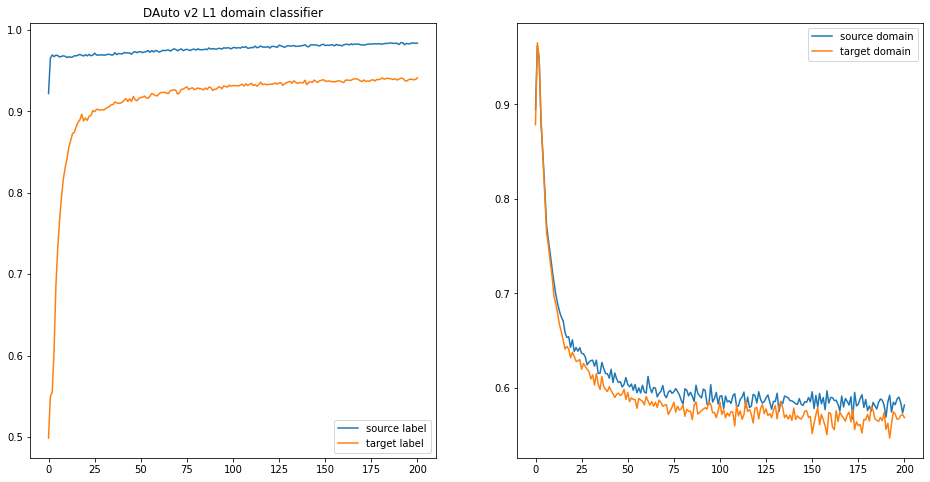

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
x = range(0, epoches)

history_DAtuo_v2_L2 = np.array(history_DAtuo_v2_L2)

ax1.plot(x, history_DAtuo_v2_L2[:,0])
ax1.plot(x, history_DAtuo_v2_L2[:,2])
ax1.set_title("DAuto v2 L2 classifier")
ax1.legend(['source label', 'target label'])

ax2.plot(x, history_DAtuo_v2_L2[:,1])
ax2.plot(x, history_DAtuo_v2_L2[:,3])
ax1.set_title("DAuto v2 L1 domain classifier")
ax2.legend(['source domain', 'target domain'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


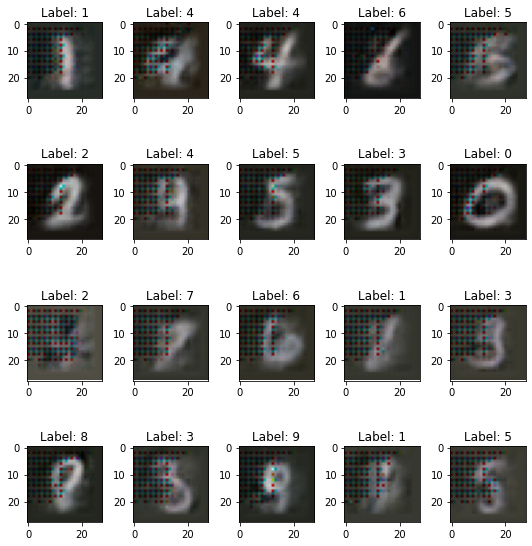

In [33]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(dauto_v2_l2, loader_source, loader_target, 200)
show_img(source_reconstrueted, target_reconstructed, source_label, target_label)

In [34]:
torch.save(dauto_v2_l1, "./model_weight/dauto_v2_l2")

# Third attempt: remove reconstruct loss of reconstruct image and oringal image

In [35]:
def train_with_autoencoder_v3(source, target, net, criterion,criterion_construct, optimizer, use_cuda, epoch):
    net.train() # Sets the module in training mode.
    total = 0
    data_target_iter = iter(target)

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0

    len_dataloader = min(len(source), len(target))

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoch * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01/(1.+10*p)**0.75

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda: source_inputs, source_label, domain_label = source_inputs.cuda(), source_label.cuda(), domain_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        class_output, domain_output, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Source image
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Source images
        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)
        loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda: target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        class_output, domain_output, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Target image
        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Target images
        loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)
        loss_t_domain = criterion(domain_output, domain_label)

        loss_construct_ts = criterion_construct(reconstruct_target, reconstruct_source)

        loss = loss_s_label + loss_s_domain + loss_t_domain  + loss_construct_ts

        loss.backward()
        optimizer.step()


    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total



### L1 loss

In [36]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.L1Loss()
dauto_v3_l1 = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    dauto_v3_l1.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(dauto_v3_l1.parameters(), lr=0.001) 

In [37]:
history_DAtuo_v3_L1 = []
for epoch in range(0, epoches):
    sl, sd, tl, td, total = train_with_autoencoder_v3(loader_source, loader_target, dauto_v3_l1, criterion, criterion_construct, optimizer,True, epoch) 
    history_DAtuo_v3_L1.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


e: 0, sl: 0.922075, sd: 0.876219, tl: 0.516710, td: 0.857772
e: 20, sl: 0.969234, sd: 0.642662, tl: 0.896468, td: 0.632395
e: 40, sl: 0.971755, sd: 0.617455, tl: 0.909088, td: 0.599910
e: 60, sl: 0.973224, sd: 0.598858, tl: 0.917785, td: 0.585236
e: 80, sl: 0.973324, sd: 0.590979, tl: 0.921908, td: 0.582582
e: 100, sl: 0.977097, sd: 0.580529, tl: 0.928068, td: 0.583617
e: 120, sl: 0.980369, sd: 0.590011, tl: 0.932292, td: 0.571982
e: 140, sl: 0.982021, sd: 0.588258, tl: 0.933894, td: 0.569328
e: 160, sl: 0.983574, sd: 0.590144, tl: 0.935630, td: 0.569278
e: 180, sl: 0.983273, sd: 0.570797, tl: 0.937066, td: 0.573668
e: 200, sl: 0.985577, sd: 0.572549, tl: 0.937133, td: 0.571681


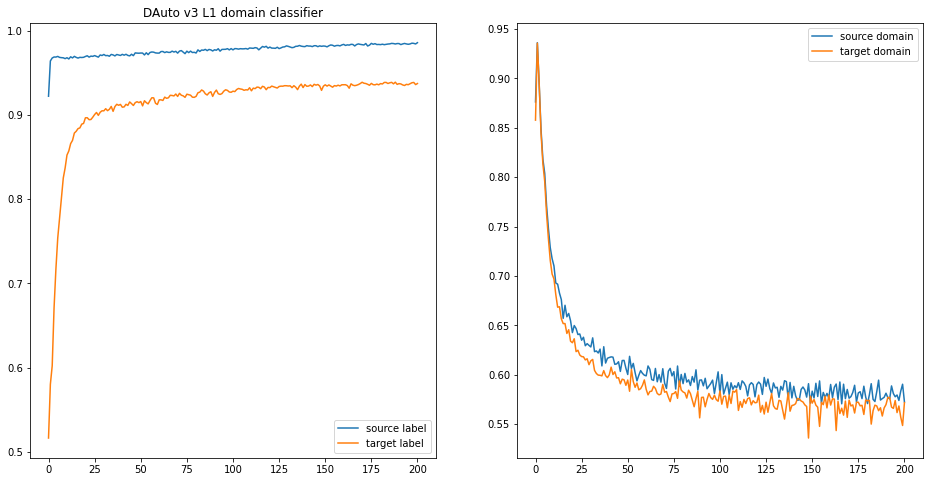

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
x = range(0, epoches)

history_DAtuo_v3_L1 = np.array(history_DAtuo_v3_L1)

ax1.plot(x, history_DAtuo_v3_L1[:,0])
ax1.plot(x, history_DAtuo_v3_L1[:,2])
ax1.set_title("DAuto v3 L1 classifier")
ax1.legend(['source label', 'target label'])

ax2.plot(x, history_DAtuo_v3_L1[:,1])
ax2.plot(x, history_DAtuo_v3_L1[:,3])
ax1.set_title("DAuto v3 L1 domain classifier")
ax2.legend(['source domain', 'target domain'])

In [39]:
torch.save(dauto_v2_l1, "./model_weight/dauto_v3_l1")

### L2 Loss

In [40]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.MSELoss()
dauto_v3_l2 = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    dauto_v3_l2.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(dauto_v3_l2.parameters(), lr=0.001) 

In [41]:
history_DAtuo_v3_L2 = []
for epoch in range(0, epoches):
    sl, sd, tl, td, total = train_with_autoencoder_v3(loader_source, loader_target, dauto_v3_l2, criterion, criterion_construct, optimizer,True, epoch) 
    history_DAtuo_v3_L2.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


e: 0, sl: 0.922025, sd: 0.888455, tl: 0.489300, td: 0.874015
e: 20, sl: 0.968283, sd: 0.651960, tl: 0.886001, td: 0.633397
e: 40, sl: 0.971655, sd: 0.602063, tl: 0.913812, td: 0.591146
e: 60, sl: 0.973174, sd: 0.598624, tl: 0.918553, td: 0.579861
e: 80, sl: 0.977564, sd: 0.593783, tl: 0.927534, td: 0.576639
e: 100, sl: 0.976846, sd: 0.594535, tl: 0.927033, td: 0.558393
e: 120, sl: 0.981387, sd: 0.600578, tl: 0.932325, td: 0.566974
e: 140, sl: 0.981788, sd: 0.584452, tl: 0.931591, td: 0.570863
e: 160, sl: 0.982305, sd: 0.576673, tl: 0.933143, td: 0.580863
e: 180, sl: 0.984024, sd: 0.583317, tl: 0.934812, td: 0.562600
e: 200, sl: 0.984492, sd: 0.576639, tl: 0.937216, td: 0.574336


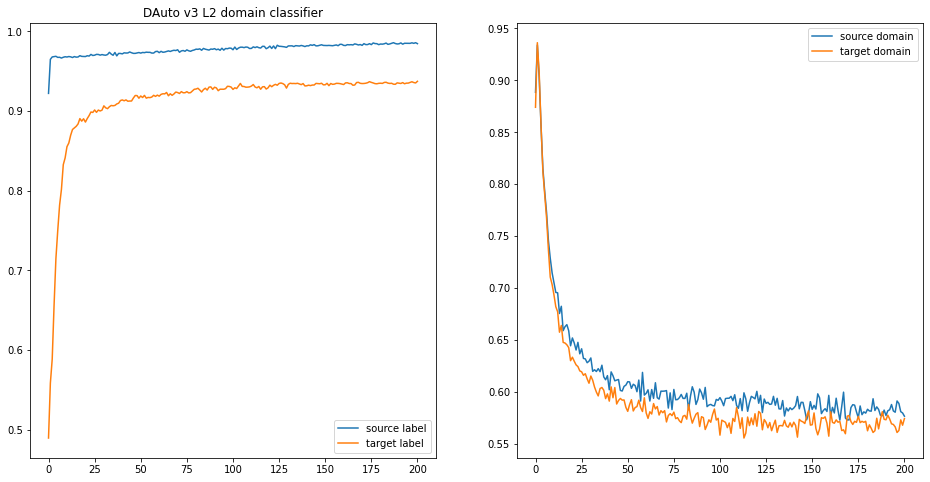

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
x = range(0, epoches)

history_DAtuo_v3_L2 = np.array(history_DAtuo_v3_L2)

ax1.plot(x, history_DAtuo_v3_L2[:,0])
ax1.plot(x, history_DAtuo_v3_L2[:,2])
ax1.set_title("DAuto v3 L2 classifier")
ax1.legend(['source label', 'target label'])

ax2.plot(x, history_DAtuo_v3_L2[:,1])
ax2.plot(x, history_DAtuo_v3_L2[:,3])
ax1.set_title("DAuto v3 L2 domain classifier")
ax2.legend(['source domain', 'target domain'])

In [43]:
torch.save(dauto_v3_l2, "./model_weight/dauto_v3_l2")

# Result

In [44]:
x = range(0, epoches)
history_DANN = np.array(history_DANN)
history_DAtuo_L1 = np.array(history_DAtuo_L1)
history_DAtuo_L2 = np.array(history_DAtuo_L2)
history_DAtuo_v2_L1 = np.array(history_DAtuo_v2_L1)
history_DAtuo_v2_L2 = np.array(history_DAtuo_v2_L2)
history_DAtuo_v3_L1 = np.array(history_DAtuo_v3_L1)
history_DAtuo_v3_L2 = np.array(history_DAtuo_v2_L2)

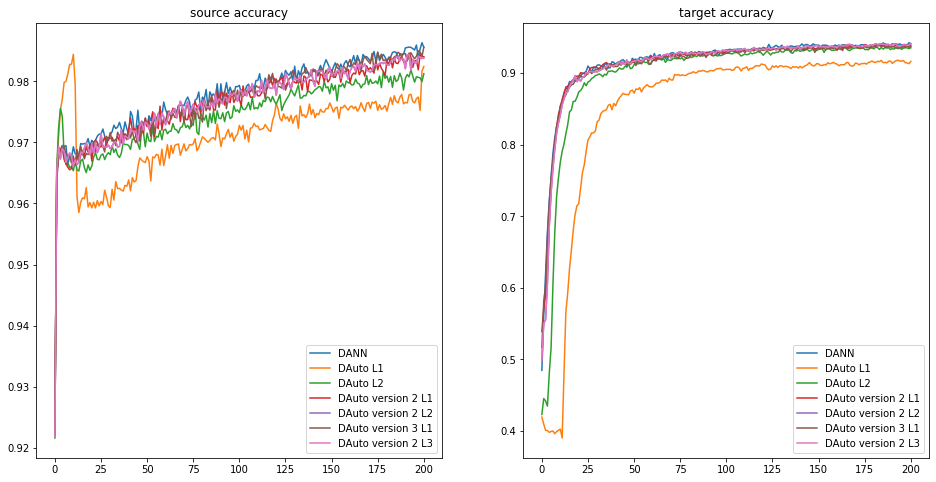

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))

ax1.plot(x, history_DANN[:,0])
ax1.plot(x, history_DAtuo_L1[:,0])
ax1.plot(x, history_DAtuo_L2[:,0])
ax1.plot(x, history_DAtuo_v2_L1[:,0])
ax1.plot(x, history_DAtuo_v2_L2[:,0])
ax1.plot(x, history_DAtuo_v3_L1[:,0])
ax1.plot(x, history_DAtuo_v3_L2[:,0])
ax1.set_title("source accuracy")
ax1.legend(['DANN', 'DAuto L1', 'DAuto L2', 'DAuto version 2 L1', 'DAuto version 2 L2', 'DAuto version 3 L1', 'DAuto version 2 L3'])

ax2.plot(x, history_DANN[:,2])
ax2.plot(x, history_DAtuo_L1[:,2])
ax2.plot(x, history_DAtuo_L2[:,2])
ax2.plot(x, history_DAtuo_v2_L1[:,2])
ax2.plot(x, history_DAtuo_v2_L2[:,2])
ax2.plot(x, history_DAtuo_v3_L1[:,2])
ax2.plot(x, history_DAtuo_v3_L2[:,2])
ax2.set_title("target accuracy")
ax2.legend(['DANN', 'DAuto L1', 'DAuto L2', 'DAuto version 2 L1', 'DAuto version 2 L2', 'DAuto version 3 L1', 'DAuto version 2 L3'])


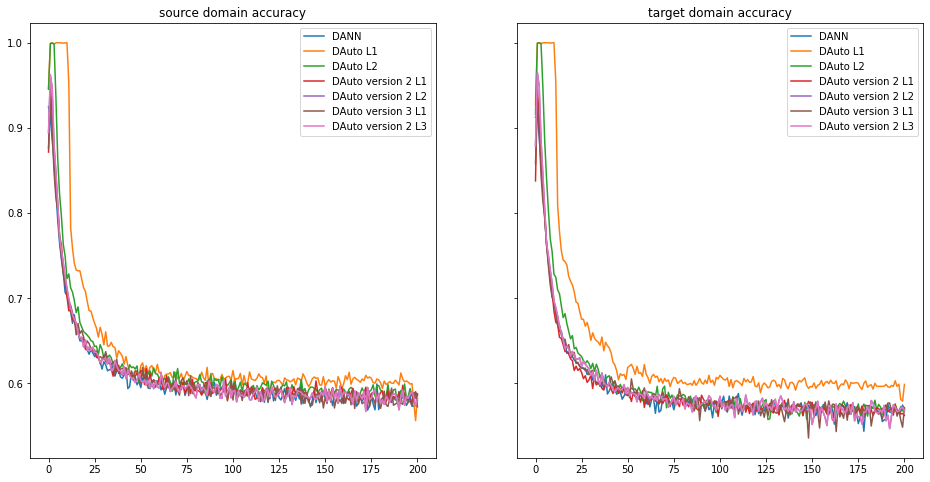

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16, 8))

ax1.plot(x, history_DANN[:,1])
ax1.plot(x, history_DAtuo_L1[:,1])
ax1.plot(x, history_DAtuo_L2[:,1])
ax1.plot(x, history_DAtuo_v2_L1[:,1])
ax1.plot(x, history_DAtuo_v2_L2[:,1])
ax1.plot(x, history_DAtuo_v3_L1[:,1])
ax1.plot(x, history_DAtuo_v3_L2[:,1])
ax1.set_title("source domain accuracy")
ax1.legend(['DANN', 'DAuto L1', 'DAuto L2', 'DAuto version 2 L1', 'DAuto version 2 L2', 'DAuto version 3 L1', 'DAuto version 2 L3'])

ax2.plot(x, history_DANN[:,3])
ax2.plot(x, history_DAtuo_L1[:,3])
ax2.plot(x, history_DAtuo_L2[:,3])
ax2.plot(x, history_DAtuo_v2_L1[:,3])
ax2.plot(x, history_DAtuo_v2_L2[:,3])
ax2.plot(x, history_DAtuo_v3_L1[:,3])
ax2.plot(x, history_DAtuo_v3_L2[:,3])
ax2.set_title("target domain accuracy")
ax2.legend(['DANN', 'DAuto L1', 'DAuto L2', 'DAuto version 2 L1', 'DAuto version 2 L2', 'DAuto version 3 L1', 'DAuto version 2 L3'])